In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install tf-nightly-2.0-preview


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


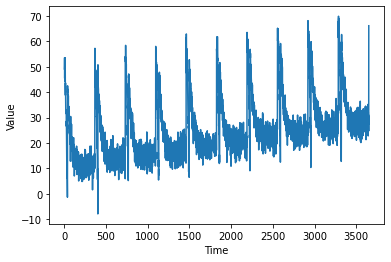

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
    
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 20s 217ms/step - loss: 8.6334 - mae: 9.0221
Epoch 2/100
94/94 [==============================] - 7s 70ms/step - loss: 8.0668 - mae: 8.5407
Epoch 3/100
94/94 [==============================] - 6s 65ms/step - loss: 7.7169 - mae: 8.2034
Epoch 4/100
94/94 [==============================] - 6s 65ms/step - loss: 7.5300 - mae: 7.9855
Epoch 5/100
94/94 [==============================] - 7s 74ms/step - loss: 7.3175 - mae: 7.8284
Epoch 6/100
94/94 [==============================] - 7s 75ms/step - loss: 7.1929 - mae: 7.7112
Epoch 7/100
94/94 [==============================] - 7s 77ms/step - loss: 7.1144 - mae: 7.6132
Epoch 8/100
94/94 [==============================] - 8s 81ms/step - loss: 6.9932 - mae: 7.5238:
Epoch 9/100
94/94 [==============================] - 7s 69ms/step - loss: 6.9375 - mae: 7.4375
Epoch 10/100
94/94 [==============================] - 6s 68ms/step - loss: 6.8299 - mae: 7.3491: 1s - l
Epoch 11/100
94/94 [==================

94/94 [==============================] - 6s 69ms/step - loss: 3.7447 - mae: 4.2197
Epoch 85/100
94/94 [==============================] - 7s 72ms/step - loss: 3.3751 - mae: 3.8335
Epoch 86/100
94/94 [==============================] - 8s 80ms/step - loss: 3.3864 - mae: 3.8635
Epoch 87/100
94/94 [==============================] - 7s 78ms/step - loss: 3.4939 - mae: 3.9586
Epoch 88/100
94/94 [==============================] - 7s 74ms/step - loss: 3.8849 - mae: 4.3678
Epoch 89/100
94/94 [==============================] - 6s 66ms/step - loss: 3.0464 - mae: 3.4975
Epoch 90/100
94/94 [==============================] - 6s 64ms/step - loss: 3.7199 - mae: 4.1882
Epoch 91/100
94/94 [==============================] - 7s 74ms/step - loss: 3.5190 - mae: 3.9930
Epoch 92/100
94/94 [==============================] - 7s 73ms/step - loss: 3.8362 - mae: 4.3278
Epoch 93/100
94/94 [==============================] - 7s 71ms/step - loss: 3.9808 - mae: 4.4388
Epoch 94/100
94/94 [==============================] -

(1e-08, 0.0001, 0.0, 30.0)

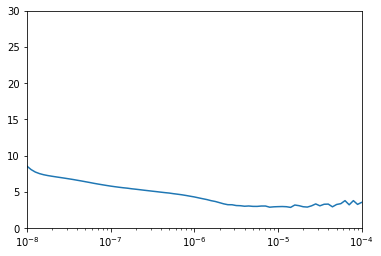

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
    
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 31s 329ms/step - loss: 76.7472 - mae: 6.0872 38
Epoch 2/500
94/94 [==============================] - 9s 97ms/step - loss: 44.3021 - mae: 4.5789
Epoch 3/500
94/94 [==============================] - 9s 97ms/step - loss: 30.3680 - mae: 3.6594
Epoch 4/500
94/94 [==============================] - 9s 97ms/step - loss: 27.8773 - mae: 3.5465
Epoch 5/500
94/94 [==============================] - 9s 98ms/step - loss: 29.9159 - mae: 3.7849
Epoch 6/500
94/94 [==============================] - 9s 98ms/step - loss: 27.7666 - mae: 3.5976
Epoch 7/500
94/94 [==============================] - 9s 98ms/step - loss: 25.6703 - mae: 3.3847 
Epoch 8/500
94/94 [==============================] - 10s 102ms/step - loss: 29.7868 - mae: 3.7700
Epoch 9/500
94/94 [==============================] - 9s 97ms/step - loss: 26.4873 - mae: 3.4511
Epoch 10/500
94/94 [==============================] - 9s 97ms/step - loss: 26.3536 - mae: 3.4439
Epoch 11/500
94/94 [===========

94/94 [==============================] - 9s 101ms/step - loss: 21.9382 - mae: 3.15380s - loss: 21.
Epoch 84/500
94/94 [==============================] - 9s 98ms/step - loss: 23.8232 - mae: 3.3684
Epoch 85/500
94/94 [==============================] - 9s 94ms/step - loss: 21.7568 - mae: 3.1581
Epoch 86/500
94/94 [==============================] - 9s 98ms/step - loss: 21.4003 - mae: 3.0892 0s - loss: 21.6529 - mae: 
Epoch 87/500
94/94 [==============================] - 11s 121ms/step - loss: 21.8715 - mae: 3.1163
Epoch 88/500
94/94 [==============================] - 11s 118ms/step - loss: 22.3488 - mae: 3.2207
Epoch 89/500
94/94 [==============================] - 9s 100ms/step - loss: 21.0505 - mae: 3.0723
Epoch 90/500
94/94 [==============================] - 10s 111ms/step - loss: 21.8077 - mae: 3.1107
Epoch 91/500
94/94 [==============================] - 10s 105ms/step - loss: 20.9340 - mae: 3.0529
Epoch 92/500
94/94 [==============================] - 10s 109ms/step - loss: 21.6356 - ma

94/94 [==============================] - 9s 92ms/step - loss: 19.9316 - mae: 2.9703
Epoch 164/500
94/94 [==============================] - 8s 89ms/step - loss: 20.5207 - mae: 3.0316 2s - ETA: 0s - loss:
Epoch 165/500
94/94 [==============================] - 9s 98ms/step - loss: 25.5945 - mae: 3.0886
Epoch 166/500
94/94 [==============================] - 9s 99ms/step - loss: 21.5182 - mae: 3.1788
Epoch 167/500
94/94 [==============================] - 9s 93ms/step - loss: 20.3144 - mae: 3.0163
Epoch 168/500
94/94 [==============================] - 9s 95ms/step - loss: 20.5712 - mae: 3.0408
Epoch 169/500
94/94 [==============================] - 8s 89ms/step - loss: 20.1264 - mae: 3.0061
Epoch 170/500
94/94 [==============================] - 11s 113ms/step - loss: 20.4353 - mae: 3.0385
Epoch 171/500
94/94 [==============================] - 12s 123ms/step - loss: 19.8199 - mae: 2.9803
Epoch 172/500
94/94 [==============================] - 10s 105ms/step - loss: 20.2069 - mae: 3.0326
Epoch 1

94/94 [==============================] - 9s 100ms/step - loss: 20.4845 - mae: 3.0274
Epoch 245/500
94/94 [==============================] - 8s 84ms/step - loss: 20.0944 - mae: 2.9923
Epoch 246/500
94/94 [==============================] - 9s 101ms/step - loss: 20.2210 - mae: 3.0096
Epoch 247/500
94/94 [==============================] - 9s 101ms/step - loss: 19.9240 - mae: 2.9593
Epoch 248/500
94/94 [==============================] - 10s 108ms/step - loss: 19.4103 - mae: 2.9453
Epoch 249/500
94/94 [==============================] - 10s 109ms/step - loss: 20.6219 - mae: 3.0314
Epoch 250/500
94/94 [==============================] - 10s 111ms/step - loss: 19.6963 - mae: 2.9389
Epoch 251/500
94/94 [==============================] - 9s 97ms/step - loss: 19.6526 - mae: 2.9205
Epoch 252/500
94/94 [==============================] - 9s 101ms/step - loss: 21.3087 - mae: 3.1703
Epoch 253/500
94/94 [==============================] - 11s 120ms/step - loss: 21.1335 - mae: 3.0823
Epoch 254/500
94/94 [=

94/94 [==============================] - 8s 81ms/step - loss: 19.2205 - mae: 2.9000
Epoch 327/500
94/94 [==============================] - 8s 86ms/step - loss: 19.1874 - mae: 2.8913 
Epoch 328/500
94/94 [==============================] - 8s 81ms/step - loss: 19.5055 - mae: 2.9380
Epoch 329/500
94/94 [==============================] - 8s 81ms/step - loss: 19.9588 - mae: 2.9926
Epoch 330/500
94/94 [==============================] - 8s 81ms/step - loss: 20.7086 - mae: 3.0529
Epoch 331/500
94/94 [==============================] - 8s 85ms/step - loss: 19.6596 - mae: 2.9611
Epoch 332/500
94/94 [==============================] - 8s 82ms/step - loss: 19.9800 - mae: 2.9809
Epoch 333/500
94/94 [==============================] - 8s 85ms/step - loss: 19.5095 - mae: 2.9392
Epoch 334/500
94/94 [==============================] - 8s 82ms/step - loss: 19.5521 - mae: 2.9160
Epoch 335/500
94/94 [==============================] - 8s 83ms/step - loss: 19.8106 - mae: 2.9821
Epoch 336/500
94/94 [============

94/94 [==============================] - 8s 90ms/step - loss: 19.2164 - mae: 2.9262
Epoch 409/500
94/94 [==============================] - 8s 86ms/step - loss: 19.3688 - mae: 2.9211
Epoch 410/500
94/94 [==============================] - 9s 92ms/step - loss: 20.4359 - mae: 3.0237
Epoch 411/500
94/94 [==============================] - 8s 84ms/step - loss: 19.5270 - mae: 2.9700
Epoch 412/500
94/94 [==============================] - 8s 81ms/step - loss: 19.3523 - mae: 2.9516
Epoch 413/500
94/94 [==============================] - 8s 81ms/step - loss: 19.8306 - mae: 2.9738
Epoch 414/500
94/94 [==============================] - 8s 82ms/step - loss: 19.2195 - mae: 2.9289
Epoch 415/500
94/94 [==============================] - 8s 82ms/step - loss: 20.0837 - mae: 2.9694
Epoch 416/500
94/94 [==============================] - 8s 82ms/step - loss: 21.4806 - mae: 3.1641
Epoch 417/500
94/94 [==============================] - 8s 84ms/step - loss: 19.5779 - mae: 2.9191
Epoch 418/500
94/94 [=============

94/94 [==============================] - 9s 92ms/step - loss: 19.0652 - mae: 2.8757
Epoch 491/500
94/94 [==============================] - 9s 95ms/step - loss: 19.0872 - mae: 2.8854
Epoch 492/500
94/94 [==============================] - 9s 93ms/step - loss: 19.7173 - mae: 2.9156
Epoch 493/500
94/94 [==============================] - 8s 85ms/step - loss: 19.4974 - mae: 2.9431
Epoch 494/500
94/94 [==============================] - 8s 87ms/step - loss: 19.2131 - mae: 2.9052
Epoch 495/500
94/94 [==============================] - 8s 89ms/step - loss: 19.4452 - mae: 2.9490
Epoch 496/500
94/94 [==============================] - 9s 92ms/step - loss: 18.9705 - mae: 2.8821
Epoch 497/500
94/94 [==============================] - 8s 86ms/step - loss: 19.1673 - mae: 2.9065
Epoch 498/500
94/94 [==============================] - 8s 87ms/step - loss: 18.9362 - mae: 2.8862
Epoch 499/500
94/94 [==============================] - 8s 85ms/step - loss: 19.0615 - mae: 2.8868
Epoch 500/500
94/94 [=============

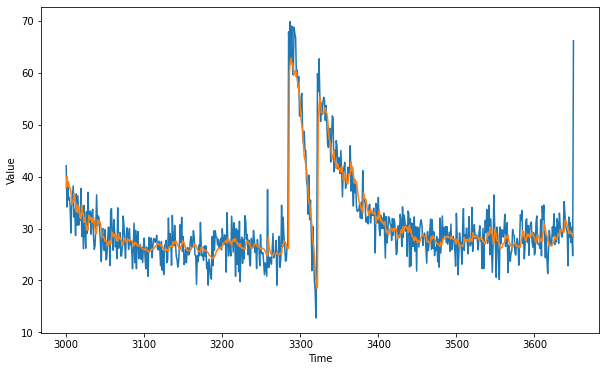

In [15]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

2.827301

<Figure size 432x288 with 0 Axes>

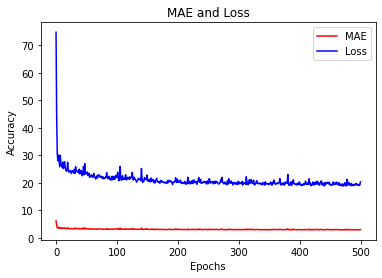

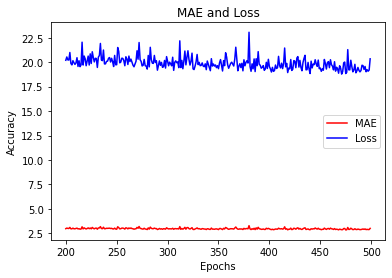

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [18]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk
